<a href="https://colab.research.google.com/github/ivanf2110/MBA/blob/main/TCC_Ivan_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC — Metodologia de Previsão de Séries Temporais no Varejo
## Da Estatística ao Aprendizado Profundo

**Autor:** Ivan Flavio Aparecido Bernardino  
**Curso:** MBA em Ciência de Dados — ICMC/USP

In [1]:
# !pip install numpy pandas matplotlib seaborn plotly statsmodels xgboost tensorflow prophet

In [2]:
# !pip install --upgrade pip

In [3]:
# !pip install tensorflow==2.13.0

In [1]:
# ====================================================
# 1. IMPORTAÇÃO DE PACOTES
# ====================================================
import sys, os, warnings, importlib, platform, json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
import os
import json
import requests

import zipfile
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

def is_available(pkg):
    try:
        return importlib.util.find_spec(pkg) is not None
    except Exception:
        return False

HAVE_XGB = is_available('xgboost')
HAVE_TF = is_available('tensorflow')
HAVE_PROPHET = is_available('prophet') or is_available('fbprophet')

print('Python:', platform.python_version())
print('NumPy:', np.__version__)
print('Pandas:', pd.__version__)
print('Matplotlib:', plt.matplotlib.__version__)
try:
    import statsmodels
    print('statsmodels:', statsmodels.__version__)
except Exception as e:
    print('statsmodels indisponível:', e)
print('xgboost disponível?', HAVE_XGB)
print('tensorflow disponível?', HAVE_TF)
print('prophet disponível?', HAVE_PROPHET)


plt.rcParams["figure.figsize"] = (32, 6)
plt.rcParams["axes.grid"] = True


import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
pd.plotting.register_matplotlib_converters()
%matplotlib inline


import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio


Python: 3.12.12
NumPy: 2.0.2
Pandas: 2.2.2
Matplotlib: 3.10.0
statsmodels: 0.14.5
xgboost disponível? True
tensorflow disponível? True
prophet disponível? True


## 2. Ingestão dos Dados (Kaggle)

In [2]:


# URL correta do conteúdo RAW
url = "https://raw.githubusercontent.com/ivanf2110/MBA/main/kaggle.json"

# Baixa e salva o arquivo
response = requests.get(url)
with open("kaggle.json", "wb") as f:
    f.write(response.content)

# Carrega o JSON corretamente
with open("kaggle.json", "r") as f:
    kaggle_token = json.load(f)

# Define as variáveis de ambiente
os.environ['KAGGLE_USERNAME'] = kaggle_token['username']
os.environ['KAGGLE_KEY'] = kaggle_token['key']

In [3]:
!pip install kaggle
!kaggle competitions download -c m5-forecasting-accuracy

m5-forecasting-accuracy.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# from google.colab import files
# files.upload()  # Escolha o arquivo kaggle.json

In [5]:
# Crie a pasta .kaggle e mova o arquivo para lá
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json

# Dê permissão ao arquivo
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
# Extraia o conteúdo do zip
with zipfile.ZipFile("m5-forecasting-accuracy.zip", "r") as zip_ref:
    zip_ref.extractall("walmart_dataset")

# Verifique os arquivos

print("Arquivos extraídos:", os.listdir("walmart_dataset"))

Arquivos extraídos: ['sales_train_validation.csv', 'sample_submission.csv', 'sales_train_evaluation.csv', 'sell_prices.csv', 'calendar.csv']


In [7]:
df = pd.read_csv("walmart_dataset/sales_train_validation.csv")
df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [8]:
print(pd.read_csv("walmart_dataset/calendar.csv"))


            date  wm_yr_wk    weekday  wday  month  year       d  \
0     2011-01-29     11101   Saturday     1      1  2011     d_1   
1     2011-01-30     11101     Sunday     2      1  2011     d_2   
2     2011-01-31     11101     Monday     3      1  2011     d_3   
3     2011-02-01     11101    Tuesday     4      2  2011     d_4   
4     2011-02-02     11101  Wednesday     5      2  2011     d_5   
...          ...       ...        ...   ...    ...   ...     ...   
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
0              NaN          NaN           NaN          NaN        0        0   
1              NaN     

Visão Geral dos Dados

O conjunto de dados M5 Forecasting – Accuracy, disponibilizado pelo Walmart no Kaggle, é composto por cinco arquivos CSV.
Ele contém informações de vendas diárias de produtos, preços e eventos especiais, com o objetivo de prever a demanda futura.

Arquivo 1: calendar.csv

Contém as datas em que os produtos foram vendidos, além de informações sobre eventos e feriados.

Colunas:

date: Data no formato “YYYY-MM-DD”.

wm_yr_wk: Identificador da semana correspondente à data.

weekday / wday: Dia da semana (sábado, domingo, …, sexta) e seu identificador numérico.

month / year: Mês e ano da data.

event_name_1 / event_type_1: Nome e tipo do primeiro evento (se houver).

event_name_2 / event_type_2: Nome e tipo do segundo evento (se houver).

snap_CA, snap_TX, snap_WI: Variáveis binárias (0 ou 1) que indicam se as lojas da Califórnia (CA), Texas (TX) ou Wisconsin (WI) permitem compras via programa SNAP na respectiva data.

Arquivo 2: sales_train_validation.csv

Contém o histórico diário de vendas (em unidades) por produto e loja, do dia d_1 ao d_1913.

Colunas:

item_id: Identificador do produto.

dept_id: Identificador do departamento ao qual o produto pertence.

cat_id: Identificador da categoria do produto.

store_id: Identificador da loja onde o produto foi vendido.

state_id: Identificador do estado onde a loja está localizada.

d_1 … d_1941: Quantidade de unidades vendidas em cada dia.

Arquivo 3: sell_prices.csv

Contém informações sobre os preços dos produtos, por loja e por semana.

Colunas:

store_id: Identificador da loja.

item_id: Identificador do produto.

wm_yr_wk: Identificador semanal (correspondente ao arquivo calendar.csv).

sell_price: Preço médio do produto naquela semana e loja.

Arquivo 5: sales_train_evaluation.csv

Semelhante ao arquivo de validação, porém com dados de vendas estendidos até o dia d_1941.
É utilizado para prever as vendas do período d_1942–d_1969.

Divisão dos conjuntos:

Treinamento: d_1 – d_1913

Validação: d_1914 – d_1941

Avaliação: d_1942 – d_1969

## 1.0 Análise exploratória e Tratamentos

In [9]:
# Funções uteis

def analisar_dataframe(df):
    resultado = {}

    for coluna in df.columns:
        info_coluna = {}
        tipo = df[coluna].dtype

        # Verifica valores nulos
        nulos = df[coluna].isnull().sum()
        if nulos > 0:
            info_coluna['nulos'] = nulos

        # Coluna categórica ou string
        if tipo == 'object' or pd.api.types.is_categorical_dtype(df[coluna]):
            info_coluna['tipo'] = 'categórica'
            categorias = df[coluna].dropna().unique().tolist()
            contagem = df[coluna].value_counts(dropna=True).to_dict()
            info_coluna['categorias_distintas'] = categorias
            info_coluna['contagem_por_categoria'] = contagem

        # Coluna numérica
        elif pd.api.types.is_numeric_dtype(df[coluna]):
            info_coluna['tipo'] = 'numérica'
            info_coluna['mínimo'] = df[coluna].min()
            info_coluna['máximo'] = df[coluna].max()
            info_coluna['mediana'] = df[coluna].median()
            info_coluna['moda'] = df[coluna].mode().tolist()

        else:
            info_coluna['tipo'] = str(tipo)

        resultado[coluna] = info_coluna

    return resultado

## 1.1 DF Calendário

In [10]:
calendar_df = pd.read_csv('walmart_dataset/calendar.csv')
calendar_df.head()

date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [11]:
calendar_df.tail()

date  wm_yr_wk    weekday  wday  month  year       d  \
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
1964           NaN          NaN           NaN          NaN        0        1   
1965           NaN          NaN           NaN          NaN        0        0   
1966           NaN          NaN           NaN          NaN        0        0   
1967           NaN          NaN           NaN          NaN        0        0   
1968  NBAFinalsEnd     Sporting  Father's day     Cultural        0        0   

      snap_WI  
1964        1  
1965        0  
1966        0  
1967        0  
1968        0

In [12]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [13]:
calendar_df.shape

(1969, 14)

In [14]:
calendar_df.isnull().sum()

date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
event_name_1    1807
event_type_1    1807
event_name_2    1964
event_type_2    1964
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [15]:
analise = analisar_dataframe(calendar_df)
for coluna, info in analise.items():
    print(f"\n📊 Coluna: {coluna}")
    for chave, valor in info.items():
        print(f"  - {chave}: {valor}")



📊 Coluna: date
  - tipo: categórica
  - categorias_distintas: ['2011-01-29', '2011-01-30', '2011-01-31', '2011-02-01', '2011-02-02', '2011-02-03', '2011-02-04', '2011-02-05', '2011-02-06', '2011-02-07', '2011-02-08', '2011-02-09', '2011-02-10', '2011-02-11', '2011-02-12', '2011-02-13', '2011-02-14', '2011-02-15', '2011-02-16', '2011-02-17', '2011-02-18', '2011-02-19', '2011-02-20', '2011-02-21', '2011-02-22', '2011-02-23', '2011-02-24', '2011-02-25', '2011-02-26', '2011-02-27', '2011-02-28', '2011-03-01', '2011-03-02', '2011-03-03', '2011-03-04', '2011-03-05', '2011-03-06', '2011-03-07', '2011-03-08', '2011-03-09', '2011-03-10', '2011-03-11', '2011-03-12', '2011-03-13', '2011-03-14', '2011-03-15', '2011-03-16', '2011-03-17', '2011-03-18', '2011-03-19', '2011-03-20', '2011-03-21', '2011-03-22', '2011-03-23', '2011-03-24', '2011-03-25', '2011-03-26', '2011-03-27', '2011-03-28', '2011-03-29', '2011-03-30', '2011-03-31', '2011-04-01', '2011-04-02', '2011-04-03', '2011-04-04', '2011-04-05'

## 1.2 DF Sell Price

In [16]:
selling_prices_df = pd.read_csv('walmart_dataset/sell_prices.csv')
selling_prices_df.head()

store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [17]:
selling_prices_df.tail()

store_id      item_id  wm_yr_wk  sell_price
6841116     WI_3  FOODS_3_827     11617         1.0
6841117     WI_3  FOODS_3_827     11618         1.0
6841118     WI_3  FOODS_3_827     11619         1.0
6841119     WI_3  FOODS_3_827     11620         1.0
6841120     WI_3  FOODS_3_827     11621         1.0

In [18]:
selling_prices_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [19]:
analise = analisar_dataframe(selling_prices_df)
for coluna, info in analise.items():
    print(f"\n📊 Coluna: {coluna}")
    for chave, valor in info.items():
        print(f"  - {chave}: {valor}")


📊 Coluna: store_id
  - tipo: categórica
  - categorias_distintas: ['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1', 'WI_2', 'WI_3']
  - contagem_por_categoria: {'TX_2': 701214, 'TX_1': 699796, 'CA_1': 698412, 'WI_3': 696094, 'CA_3': 693990, 'TX_3': 691112, 'CA_4': 679025, 'WI_2': 678171, 'WI_1': 665912, 'CA_2': 637395}

📊 Coluna: item_id
  - tipo: categórica
  - categorias_distintas: ['HOBBIES_1_001', 'HOBBIES_1_002', 'HOBBIES_1_003', 'HOBBIES_1_004', 'HOBBIES_1_005', 'HOBBIES_1_006', 'HOBBIES_1_007', 'HOBBIES_1_008', 'HOBBIES_1_009', 'HOBBIES_1_010', 'HOBBIES_1_011', 'HOBBIES_1_012', 'HOBBIES_1_013', 'HOBBIES_1_014', 'HOBBIES_1_015', 'HOBBIES_1_016', 'HOBBIES_1_017', 'HOBBIES_1_018', 'HOBBIES_1_019', 'HOBBIES_1_020', 'HOBBIES_1_021', 'HOBBIES_1_022', 'HOBBIES_1_023', 'HOBBIES_1_024', 'HOBBIES_1_025', 'HOBBIES_1_026', 'HOBBIES_1_027', 'HOBBIES_1_028', 'HOBBIES_1_029', 'HOBBIES_1_030', 'HOBBIES_1_031', 'HOBBIES_1_032', 'HOBBIES_1_033', 'HOBBIES_1_034', 'HOBBIES_1_035', '

In [20]:
selling_prices_df.isnull().sum()

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

## 1.3 DF Sales

In [21]:
sales_train_valid_df = pd.read_csv('walmart_dataset/sales_train_validation.csv')
sales_train_valid_df.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [22]:
sales_train_valid_df.tail()

id      item_id  dept_id cat_id store_id  \
30485  FOODS_3_823_WI_3_validation  FOODS_3_823  FOODS_3  FOODS     WI_3   
30486  FOODS_3_824_WI_3_validation  FOODS_3_824  FOODS_3  FOODS     WI_3   
30487  FOODS_3_825_WI_3_validation  FOODS_3_825  FOODS_3  FOODS     WI_3   
30488  FOODS_3_826_WI_3_validation  FOODS_3_826  FOODS_3  FOODS     WI_3   
30489  FOODS_3_827_WI_3_validation  FOODS_3_827  FOODS_3  FOODS     WI_3   

      state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  \
30485       WI    0    0    2    2  ...       2       0       0       0   
30486       WI    0    0    0    0  ...       0       0       0       0   
30487       WI    0    6    0    2  ...       2       1       0       2   
30488       WI    0    0    0    0  ...       0       0       1       0   
30489       WI    0    0    0    0  ...       0       0       0       0   

       d_1908  d_1909  d_1910  d_1911  d_1912  d_1913  
30485       0       0       1       0       0       1  
30486       0       0       0       0       1       0  
30487       0       1       0       0       1       0  
30488       0       1       0       3       1       3  
30489       0       0       0       0       0       0  

[5 rows x 1919 columns]

In [23]:
sales_train_valid_df.dtypes

id          object
item_id     object
dept_id     object
cat_id      object
store_id    object
             ...  
d_1909       int64
d_1910       int64
d_1911       int64
d_1912       int64
d_1913       int64
Length: 1919, dtype: object

In [24]:
analise = analisar_dataframe(sales_train_valid_df)
for coluna, info in analise.items():
    if coluna.startswith('d_'):
        continue  # pula colunas que começam com 'd_'

    print(f"\n📊 Coluna: {coluna}")
    for chave, valor in info.items():
        print(f"  - {chave}: {valor}")



📊 Coluna: id
  - tipo: categórica
  - categorias_distintas: ['HOBBIES_1_001_CA_1_validation', 'HOBBIES_1_002_CA_1_validation', 'HOBBIES_1_003_CA_1_validation', 'HOBBIES_1_004_CA_1_validation', 'HOBBIES_1_005_CA_1_validation', 'HOBBIES_1_006_CA_1_validation', 'HOBBIES_1_007_CA_1_validation', 'HOBBIES_1_008_CA_1_validation', 'HOBBIES_1_009_CA_1_validation', 'HOBBIES_1_010_CA_1_validation', 'HOBBIES_1_011_CA_1_validation', 'HOBBIES_1_012_CA_1_validation', 'HOBBIES_1_013_CA_1_validation', 'HOBBIES_1_014_CA_1_validation', 'HOBBIES_1_015_CA_1_validation', 'HOBBIES_1_016_CA_1_validation', 'HOBBIES_1_017_CA_1_validation', 'HOBBIES_1_018_CA_1_validation', 'HOBBIES_1_019_CA_1_validation', 'HOBBIES_1_020_CA_1_validation', 'HOBBIES_1_021_CA_1_validation', 'HOBBIES_1_022_CA_1_validation', 'HOBBIES_1_023_CA_1_validation', 'HOBBIES_1_024_CA_1_validation', 'HOBBIES_1_025_CA_1_validation', 'HOBBIES_1_026_CA_1_validation', 'HOBBIES_1_027_CA_1_validation', 'HOBBIES_1_028_CA_1_validation', 'HOBBIES_1_029

## 1.4 DF Submission

In [25]:
sample_sub_df = pd.read_csv('walmart_dataset/sample_submission.csv')
sample_sub_df.head()

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  \
0  HOBBIES_1_001_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
1  HOBBIES_1_002_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
2  HOBBIES_1_003_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
3  HOBBIES_1_004_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   
4  HOBBIES_1_005_CA_1_validation   0   0   0   0   0   0   0   0   0  ...   

   F19  F20  F21  F22  F23  F24  F25  F26  F27  F28  
0    0    0    0    0    0    0    0    0    0    0  
1    0    0    0    0    0    0    0    0    0    0  
2    0    0    0    0    0    0    0    0    0    0  
3    0    0    0    0    0    0    0    0    0    0  
4    0    0    0    0    0    0    0    0    0    0  

[5 rows x 29 columns]

In [26]:
sample_sub_df.tail()

id  F1  F2  F3  F4  F5  F6  F7  F8  F9  ...  \
60975  FOODS_3_823_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60976  FOODS_3_824_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60977  FOODS_3_825_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60978  FOODS_3_826_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   
60979  FOODS_3_827_WI_3_evaluation   0   0   0   0   0   0   0   0   0  ...   

       F19  F20  F21  F22  F23  F24  F25  F26  F27  F28  
60975    0    0    0    0    0    0    0    0    0    0  
60976    0    0    0    0    0    0    0    0    0    0  
60977    0    0    0    0    0    0    0    0    0    0  
60978    0    0    0    0    0    0    0    0    0    0  
60979    0    0    0    0    0    0    0    0    0    0  

[5 rows x 29 columns]

In [27]:
sample_sub_df.dtypes

id     object
F1      int64
F2      int64
F3      int64
F4      int64
F5      int64
F6      int64
F7      int64
F8      int64
F9      int64
F10     int64
F11     int64
F12     int64
F13     int64
F14     int64
F15     int64
F16     int64
F17     int64
F18     int64
F19     int64
F20     int64
F21     int64
F22     int64
F23     int64
F24     int64
F25     int64
F26     int64
F27     int64
F28     int64
dtype: object

In [28]:
analise = analisar_dataframe(sample_sub_df)
for coluna, info in analise.items():
    print(f"\n📊 Coluna: {coluna}")
    for chave, valor in info.items():
        print(f"  - {chave}: {valor}")



📊 Coluna: id
  - tipo: categórica
  - categorias_distintas: ['HOBBIES_1_001_CA_1_validation', 'HOBBIES_1_002_CA_1_validation', 'HOBBIES_1_003_CA_1_validation', 'HOBBIES_1_004_CA_1_validation', 'HOBBIES_1_005_CA_1_validation', 'HOBBIES_1_006_CA_1_validation', 'HOBBIES_1_007_CA_1_validation', 'HOBBIES_1_008_CA_1_validation', 'HOBBIES_1_009_CA_1_validation', 'HOBBIES_1_010_CA_1_validation', 'HOBBIES_1_011_CA_1_validation', 'HOBBIES_1_012_CA_1_validation', 'HOBBIES_1_013_CA_1_validation', 'HOBBIES_1_014_CA_1_validation', 'HOBBIES_1_015_CA_1_validation', 'HOBBIES_1_016_CA_1_validation', 'HOBBIES_1_017_CA_1_validation', 'HOBBIES_1_018_CA_1_validation', 'HOBBIES_1_019_CA_1_validation', 'HOBBIES_1_020_CA_1_validation', 'HOBBIES_1_021_CA_1_validation', 'HOBBIES_1_022_CA_1_validation', 'HOBBIES_1_023_CA_1_validation', 'HOBBIES_1_024_CA_1_validation', 'HOBBIES_1_025_CA_1_validation', 'HOBBIES_1_026_CA_1_validation', 'HOBBIES_1_027_CA_1_validation', 'HOBBIES_1_028_CA_1_validation', 'HOBBIES_1_029

## 2. Entendimento dos dados

In [29]:
date_col = [col for col in sales_train_valid_df if col.startswith('d_')]
print(date_col)

['d_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9', 'd_10', 'd_11', 'd_12', 'd_13', 'd_14', 'd_15', 'd_16', 'd_17', 'd_18', 'd_19', 'd_20', 'd_21', 'd_22', 'd_23', 'd_24', 'd_25', 'd_26', 'd_27', 'd_28', 'd_29', 'd_30', 'd_31', 'd_32', 'd_33', 'd_34', 'd_35', 'd_36', 'd_37', 'd_38', 'd_39', 'd_40', 'd_41', 'd_42', 'd_43', 'd_44', 'd_45', 'd_46', 'd_47', 'd_48', 'd_49', 'd_50', 'd_51', 'd_52', 'd_53', 'd_54', 'd_55', 'd_56', 'd_57', 'd_58', 'd_59', 'd_60', 'd_61', 'd_62', 'd_63', 'd_64', 'd_65', 'd_66', 'd_67', 'd_68', 'd_69', 'd_70', 'd_71', 'd_72', 'd_73', 'd_74', 'd_75', 'd_76', 'd_77', 'd_78', 'd_79', 'd_80', 'd_81', 'd_82', 'd_83', 'd_84', 'd_85', 'd_86', 'd_87', 'd_88', 'd_89', 'd_90', 'd_91', 'd_92', 'd_93', 'd_94', 'd_95', 'd_96', 'd_97', 'd_98', 'd_99', 'd_100', 'd_101', 'd_102', 'd_103', 'd_104', 'd_105', 'd_106', 'd_107', 'd_108', 'd_109', 'd_110', 'd_111', 'd_112', 'd_113', 'd_114', 'd_115', 'd_116', 'd_117', 'd_118', 'd_119', 'd_120', 'd_121', 'd_122', 'd_123', 

state_id
CA    12196
TX     9147
WI     9147
Name: count, dtype: int64


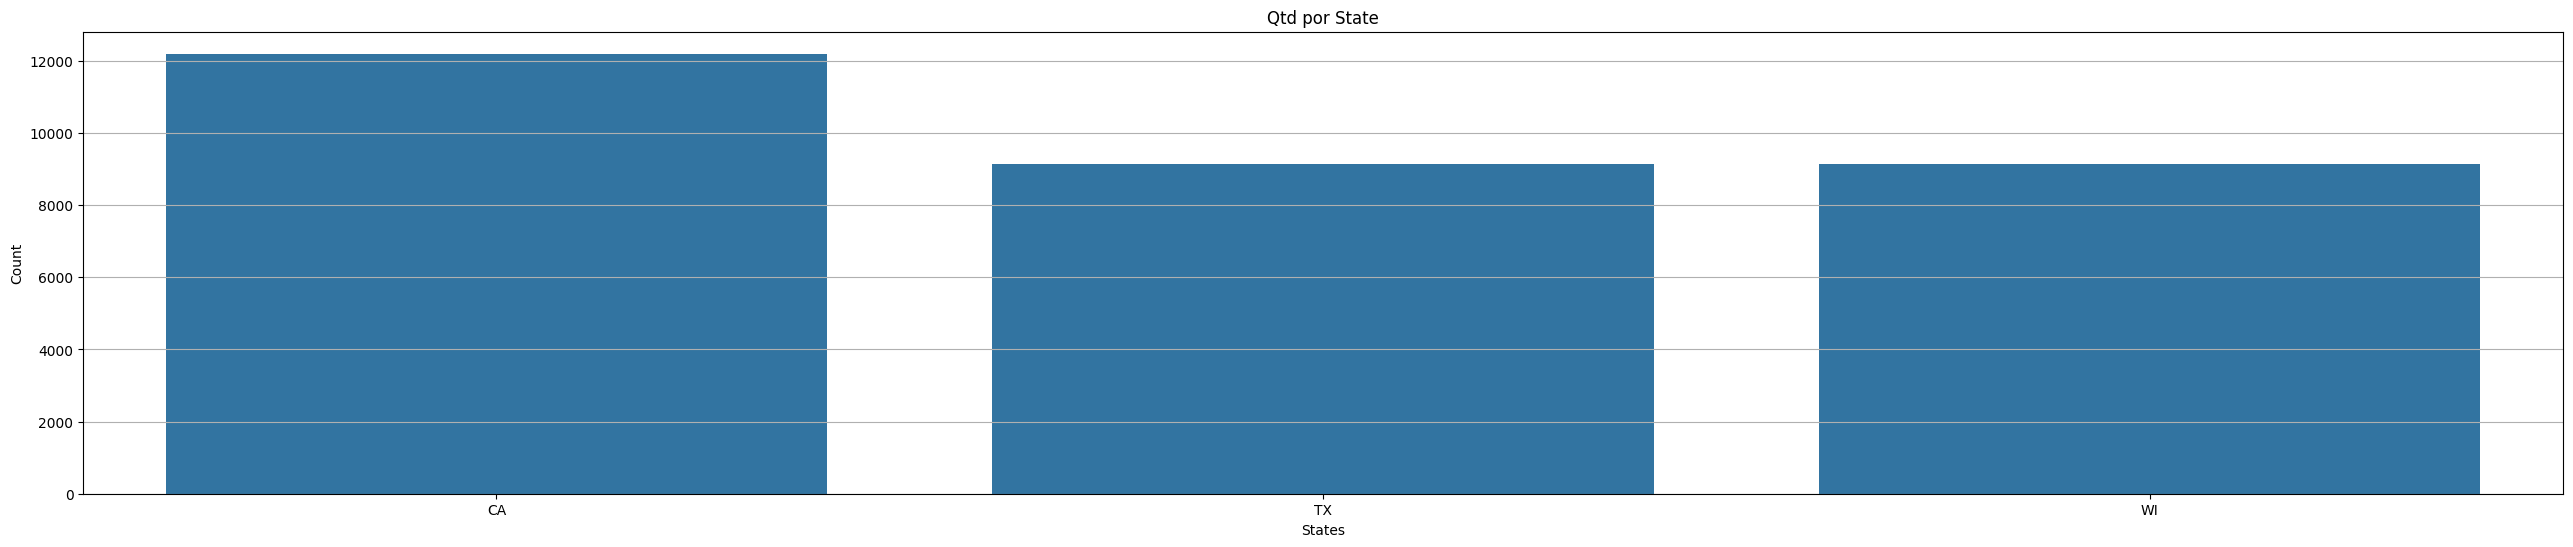

In [30]:
# Contagem por states

sales_state = sales_train_valid_df.state_id.value_counts()
print(sales_state)

# gráfico
sales_state_df = sales_state.reset_index()
sales_state_df.columns = ['state_id', 'count']

# Gráfico de barras
sns.barplot(x='state_id', y='count', data=sales_state_df)
plt.xlabel('States')
plt.ylabel('Count')
plt.title('Qtd por State')
plt.show()


In [31]:
# Participação por state (qtd)
percent_state = sales_train_valid_df.state_id.value_counts()/sales_train_valid_df.shape[0] * 100
print(percent_state)

state_id
CA    40.0
TX    30.0
WI    30.0
Name: count, dtype: float64


In [32]:
# Inclusão do total de vendas e depois total por state
sales_train_valid_df['total_sales'] = sales_train_valid_df[date_col].sum(axis=1)

sales_train_valid_df.groupby('state_id').agg({'total_sales':'sum'}).reset_index()

sales_train_valid_df.groupby('state_id').agg({'total_sales':'sum'})/sales_train_valid_df.total_sales.sum() * 100



total_sales
state_id             
CA          43.649240
TX          28.767621
WI          27.583139

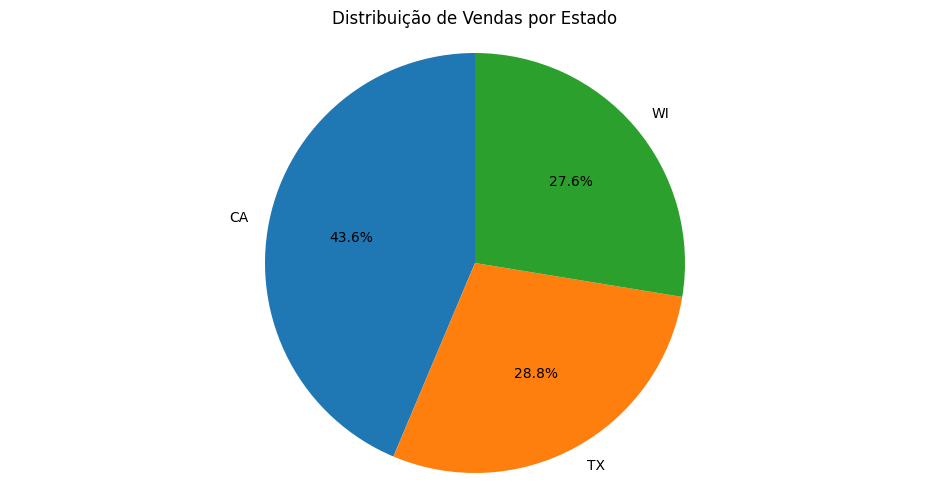

In [33]:
aux = sales_train_valid_df.groupby('state_id').agg({'total_sales':'sum'})/sales_train_valid_df.total_sales.sum() * 100
aux_percent = aux / aux.total_sales.sum() * 100

# Preparar dados para o gráfico
labels = aux_percent.index.tolist()
sizes = aux_percent['total_sales'].tolist()

# Gráfico de pizza
plt.figure(figsize=(12, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Vendas por Estado')
plt.axis('equal')
plt.show()




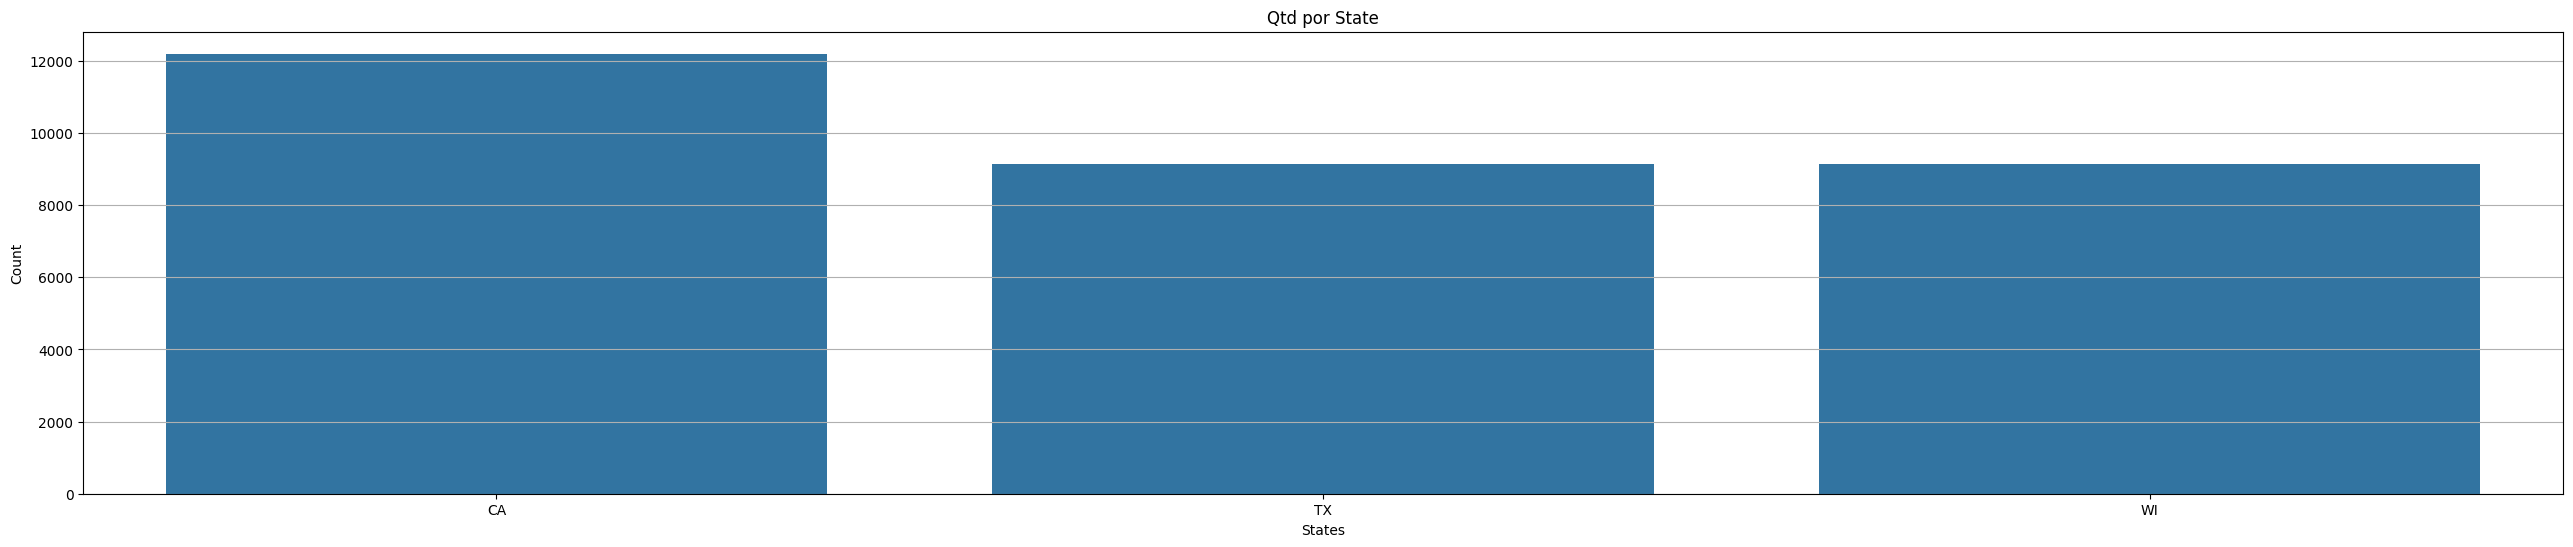

In [34]:
# gráfico em valor
sales_state_df = sales_state.reset_index()
sales_state_df.columns = ['state_id', 'count']

# Gráfico de barras
sns.barplot(x='state_id', y='count', data=sales_state_df)
plt.xlabel('States')
plt.ylabel('Count')
plt.title('Qtd por State')
plt.show()

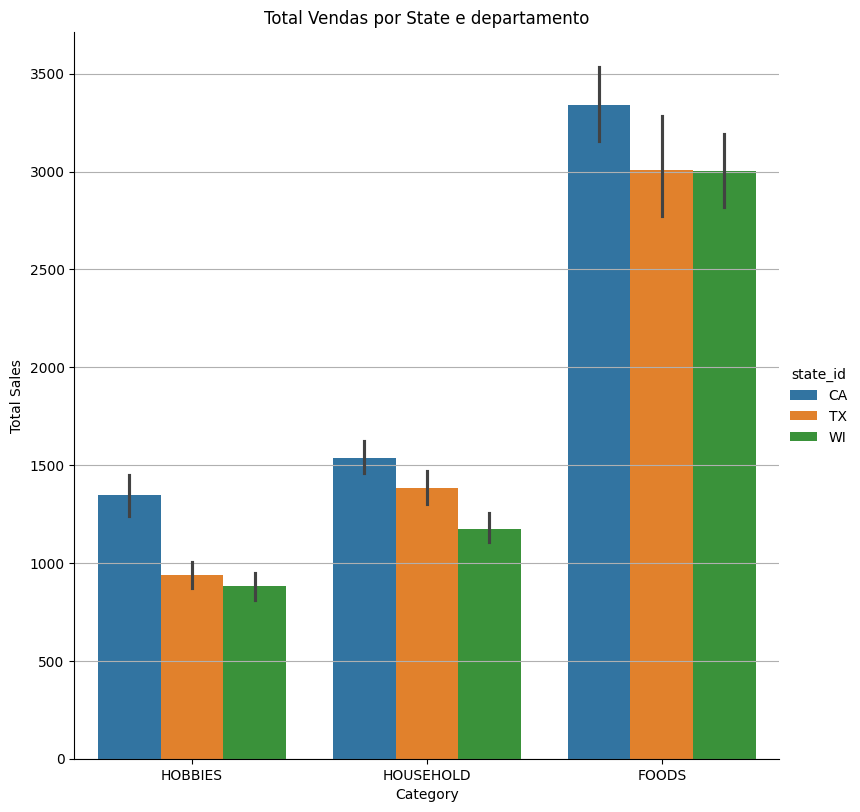

In [35]:
# Seleciona apenas colunas de vendas (que começam com 'd_')
vendas_cols = [col for col in sales_train_valid_df.columns if col.startswith('d_')]

# Soma apenas essas colunas
sales_train_valid_df['total_sales'] = sales_train_valid_df[vendas_cols].sum(axis=1)

# gráfico
sns.catplot(x='cat_id', y='total_sales',
            hue='state_id',
            data=sales_train_valid_df, kind='bar',
            height=8, aspect=1)

plt.title('Total Vendas por State e departamento')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.show()


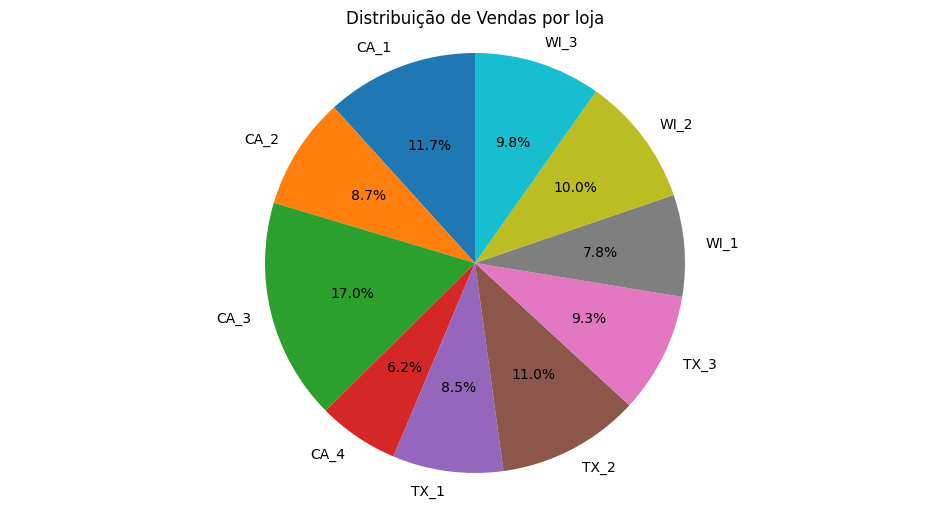

In [36]:
aux = sales_train_valid_df.groupby('store_id').agg({'total_sales':'sum'})/sales_train_valid_df.total_sales.sum() * 100
aux_percent = aux / aux.total_sales.sum() * 100

# Preparar dados para o gráfico
labels = aux_percent.index.tolist()
sizes = aux_percent['total_sales'].tolist()

# Gráfico de pizza
plt.figure(figsize=(12, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Vendas por loja')
plt.axis('equal')
plt.show()




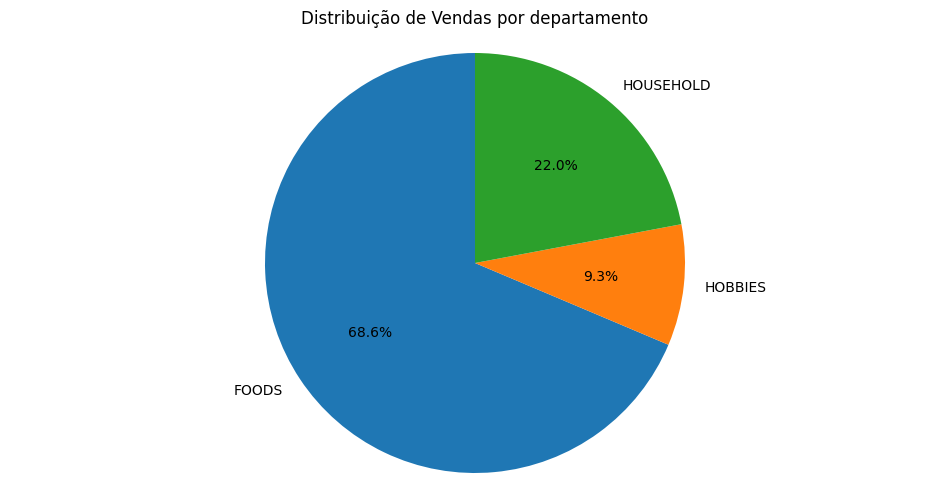

In [37]:
aux = sales_train_valid_df.groupby('cat_id').agg({'total_sales':'sum'})/sales_train_valid_df.total_sales.sum() * 100
aux_percent = aux / aux.total_sales.sum() * 100

# Preparar dados para o gráfico
labels = aux_percent.index.tolist()
sizes = aux_percent['total_sales'].tolist()

# Gráfico de pizza
plt.figure(figsize=(12, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Distribuição de Vendas por departamento')
plt.axis('equal')
plt.show()




In [38]:
# Série de vendas por states


# Colunas de demanda
d_cols = [c for c in sales_train_valid_df.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias
state_series = sales_train_valid_df.groupby('state_id')[d_cols].sum()

# Lista de estados
ids = state_series.index.tolist()
n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Estado: {state}" for state in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, state in enumerate(ids):
    x = np.arange(len(d_cols))
    y = state_series.loc[state].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Demanda agregada por estado ao longo do tempo")
fig.show()

In [39]:
# departamento por state CA

# Colunas de demanda
d_cols = [c for c in sales_train_valid_df.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias
aux = sales_train_valid_df[sales_train_valid_df['state_id'] == 'CA']
aux = aux.groupby('cat_id')[d_cols].sum()

# Lista de estados
ids = aux.index.tolist()

n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Depart: {depart}" for depart in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, depart in enumerate(ids):
    x = np.arange(len(d_cols))
    y = aux.loc[depart].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Demanda agregada por departamento em CA ao longo do tempo")
fig.show()


In [40]:
# departamento por state TX

# Colunas de demanda
d_cols = [c for c in sales_train_valid_df.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias
aux = sales_train_valid_df[sales_train_valid_df['state_id'] == 'TX']
aux = aux.groupby('cat_id')[d_cols].sum()

# Lista de estados
ids = aux.index.tolist()

n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Depart: {depart}" for depart in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, depart in enumerate(ids):
    x = np.arange(len(d_cols))
    y = aux.loc[depart].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Demanda agregada por departamento em TX ao longo do tempo")
fig.show()


In [41]:
# departamento por state WI

# Colunas de demanda
d_cols = [c for c in sales_train_valid_df.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias
aux = sales_train_valid_df[sales_train_valid_df['state_id'] == 'WI']
aux = aux.groupby('cat_id')[d_cols].sum()

# Lista de estados
ids = aux.index.tolist()

n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Depart: {depart}" for depart in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, depart in enumerate(ids):
    x = np.arange(len(d_cols))
    y = aux.loc[depart].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Demanda agregada por departamento em WI ao longo do tempo")
fig.show()


In [42]:
# MAIORES PRODUTOS DE CADA CATEGORIA

# IDs únicos top 3 de cada departamento
aux = sales_train_valid_df.groupby(['cat_id', 'item_id']).agg({'total_sales': 'sum'}).reset_index()

# Aplica rank por dept_id e filtra os top 3
aux = aux.groupby('cat_id').apply(lambda x: x.nlargest(3, 'total_sales')).reset_index(drop=True)
aux = aux.sort_values(by=['cat_id', 'total_sales'], ascending=[True, False])
print(aux)

ids = aux['item_id'].tolist()


# Lista de item_ids únicos
ids = list(set(aux['item_id']))
d_cols = [c for c in sales_train_valid_df.columns if 'd_' in c]

# Número de itens a plotar
n = len(ids)

# Cria subplots dinâmicos
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Produto: {item}" for item in ids])

# Adiciona os gráficos
for i, item_id in enumerate(ids):
    x = sales_train_valid_df.loc[sales_train_valid_df['item_id'] == item_id].set_index('item_id')[d_cols].values[0]
    cor = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
    fig.add_trace(go.Scatter(x=np.arange(len(x)), y=x, showlegend=False,
                             mode='lines', marker=dict(color=cor[i % len(cor)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Demanda ao longo do tempo por item_id")
fig.show()


      cat_id          item_id  total_sales
0      FOODS      FOODS_3_090      1002529
1      FOODS      FOODS_3_586       920242
2      FOODS      FOODS_3_252       565299
3    HOBBIES    HOBBIES_1_371       122565
4    HOBBIES    HOBBIES_1_348       105876
5    HOBBIES    HOBBIES_1_268        95171
6  HOUSEHOLD  HOUSEHOLD_1_334       171275
7  HOUSEHOLD  HOUSEHOLD_1_459       170532
8  HOUSEHOLD  HOUSEHOLD_1_521       153340


In [43]:
# departamento por state CA

# Colunas de demanda
d_cols = [c for c in sales_train_valid_df.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias
aux = sales_train_valid_df[sales_train_valid_df['state_id'] == 'CA']
aux = aux.groupby('store_id')[d_cols].sum()

# Lista de estados
ids = aux.index.tolist()

n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Depart: {depart}" for depart in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, depart in enumerate(ids):
    x = np.arange(len(d_cols))
    y = aux.loc[depart].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Demanda agregada por LOJA EM em CA ao longo do tempo")
fig.show()


##3.0 EDA Do estado da California

In [58]:
df_ca = sales_train_valid_df.copy()
df_ca = df_ca[df_ca['state_id'] == 'CA']
df_ca = df_ca[df_ca['store_id'] == 'CA_1']
df_ca.head()


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1905  d_1906  d_1907  d_1908  d_1909  \
0       CA    0    0    0    0  ...       3       0       1       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       1   
2       CA    0    0    0    0  ...       1       2       1       1       1   
3       CA    0    0    0    0  ...       0       5       4       1       0   
4       CA    0    0    0    0  ...       1       1       0       1       1   

   d_1910  d_1911  d_1912  d_1913  total_sales  
0       3       0       1       1          600  
1       0       0       0       0          493  
2       0       1       1       1          288  
3       1       3       7       2         3288  
4       2       2       2       4         1849  

[5 rows x 1920 columns]

In [45]:
# departamento por state CA

# Colunas de demanda
d_cols = [c for c in df_ca.columns if c.startswith('d_')]

# Agrupa por estado e soma as demandas diárias
aux = df_ca.groupby('cat_id')[d_cols].sum()

# Lista de estados
ids = aux.index.tolist()

n = len(ids)

# Cria subplots
fig = make_subplots(rows=n, cols=1,
                    subplot_titles=[f"Depart: {depart}" for depart in ids])

# Adiciona os gráficos
cores = ['mediumseagreen', 'royalblue', 'darkorange', 'firebrick', 'goldenrod', 'slateblue']
for i, depart in enumerate(ids):
    x = np.arange(len(d_cols))
    y = aux.loc[depart].values
    fig.add_trace(go.Scatter(x=x, y=y, showlegend=False,
                             mode='lines', marker=dict(color=cores[i % len(cores)])),
                  row=i+1, col=1)

# Layout final
fig.update_layout(height=300 * n, title_text="Demanda agregada por DEPARTAMENTO EM em CA ao longo do tempo")
fig.show()


In [59]:
df_ca = pd.melt(df_ca, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id',
                                     'state_id'], var_name='day', value_name='demand')
df_ca = df_ca[df_ca['day'] != 'total_sales']
df_ca


id        item_id    dept_id   cat_id  \
0        HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1        HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2        HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3        HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4        HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                ...            ...        ...      ...   
5832732    FOODS_3_823_CA_1_validation    FOODS_3_823    FOODS_3    FOODS   
5832733    FOODS_3_824_CA_1_validation    FOODS_3_824    FOODS_3    FOODS   
5832734    FOODS_3_825_CA_1_validation    FOODS_3_825    FOODS_3    FOODS   
5832735    FOODS_3_826_CA_1_validation    FOODS_3_826    FOODS_3    FOODS   
5832736    FOODS_3_827_CA_1_validation    FOODS_3_827    FOODS_3    FOODS   

        store_id state_id     day  demand  
0           CA_1       CA     d_1       0  
1           CA_1       CA     d_1       0  
2           CA_1       CA     d_1       0  
3           CA_1       CA     d_1       0  
4           CA_1       CA     d_1       0  
...          ...      ...     ...     ...  
5832732     CA_1       CA  d_1913       1  
5832733     CA_1       CA  d_1913       0  
5832734     CA_1       CA  d_1913       2  
5832735     CA_1       CA  d_1913       0  
5832736     CA_1       CA  d_1913      21  

[5832737 rows x 8 columns]

In [61]:
# inserir infos de calendario
df_ca = pd.merge(df_ca, calendar_df, left_on="day", right_on="d", how="left")
df_ca


id        item_id    dept_id   cat_id  \
0        HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1        HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2        HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3        HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4        HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                                ...            ...        ...      ...   
5832732    FOODS_3_823_CA_1_validation    FOODS_3_823    FOODS_3    FOODS   
5832733    FOODS_3_824_CA_1_validation    FOODS_3_824    FOODS_3    FOODS   
5832734    FOODS_3_825_CA_1_validation    FOODS_3_825    FOODS_3    FOODS   
5832735    FOODS_3_826_CA_1_validation    FOODS_3_826    FOODS_3    FOODS   
5832736    FOODS_3_827_CA_1_validation    FOODS_3_827    FOODS_3    FOODS   

        store_id state_id     day  demand        date  wm_yr_wk  ... month  \
0           CA_1       CA     d_1       0  2011-01-29     11101  ...     1   
1           CA_1       CA     d_1       0  2011-01-29     11101  ...     1   
2           CA_1       CA     d_1       0  2011-01-29     11101  ...     1   
3           CA_1       CA     d_1       0  2011-01-29     11101  ...     1   
4           CA_1       CA     d_1       0  2011-01-29     11101  ...     1   
...          ...      ...     ...     ...         ...       ...  ...   ...   
5832732     CA_1       CA  d_1913       1  2016-04-24     11613  ...     4   
5832733     CA_1       CA  d_1913       0  2016-04-24     11613  ...     4   
5832734     CA_1       CA  d_1913       2  2016-04-24     11613  ...     4   
5832735     CA_1       CA  d_1913       0  2016-04-24     11613  ...     4   
5832736     CA_1       CA  d_1913      21  2016-04-24     11613  ...     4   

         year       d  event_name_1 event_type_1 event_name_2 event_type_2  \
0        2011     d_1           NaN          NaN          NaN          NaN   
1        2011     d_1           NaN          NaN          NaN          NaN   
2        2011     d_1           NaN          NaN          NaN          NaN   
3        2011     d_1           NaN          NaN          NaN          NaN   
4        2011     d_1           NaN          NaN          NaN          NaN   
...       ...     ...           ...          ...          ...          ...   
5832732  2016  d_1913           NaN          NaN          NaN          NaN   
5832733  2016  d_1913           NaN          NaN          NaN          NaN   
5832734  2016  d_1913           NaN          NaN          NaN          NaN   
5832735  2016  d_1913           NaN          NaN          NaN          NaN   
5832736  2016  d_1913           NaN          NaN          NaN          NaN   

        snap_CA snap_TX  snap_WI  
0             0       0        0  
1             0       0        0  
2             0       0        0  
3             0       0        0  
4             0       0        0  
...         ...     ...      ...  
5832732       0       0        0  
5832733       0       0        0  
5832734       0       0        0  
5832735       0       0        0  
5832736       0       0        0  

[5832737 rows x 22 columns]

In [63]:

new_CA_1 = pd.merge(df_ca, selling_prices_df, left_on=["store_id", "item_id", "wm_yr_wk"],
                    right_on=["store_id", "item_id", "wm_yr_wk"], how="left")

new_CA_1["day_int"] = new_CA_1.day.apply(lambda x: int(x.split("_")[-1]))

new_CA_1.head()

id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  day  demand        date  wm_yr_wk  ...    d  event_name_1  \
0       CA  d_1       0  2011-01-29     11101  ...  d_1           NaN   
1       CA  d_1       0  2011-01-29     11101  ...  d_1           NaN   
2       CA  d_1       0  2011-01-29     11101  ...  d_1           NaN   
3       CA  d_1       0  2011-01-29     11101  ...  d_1           NaN   
4       CA  d_1       0  2011-01-29     11101  ...  d_1           NaN   

   event_type_1  event_name_2 event_type_2 snap_CA snap_TX snap_WI sell_price  \
0           NaN           NaN          NaN       0       0       0        NaN   
1           NaN           NaN          NaN       0       0       0        NaN   
2           NaN           NaN          NaN       0       0       0        NaN   
3           NaN           NaN          NaN       0       0       0        NaN   
4           NaN           NaN          NaN       0       0       0        NaN   

   day_int  
0        1  
1        1  
2        1  
3        1  
4        1  

[5 rows x 24 columns]

In [64]:
day_sum = new_CA_1.groupby("day_int")[["sell_price", "demand"]].agg("sum").reset_index()

In [65]:
# Plot demanda e vendas
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Scatter(x=day_sum.day_int,
                         y=day_sum.demand,
                         mode="lines",
                         name="demand",
                         ),

              row=1,col=1
              )

fig.add_trace(go.Scatter(x=day_sum.day_int,
                         y=day_sum.sell_price,
                         mode="lines",
                         name="sell_price"
                         ),

              row=2,col=1
              )

fig.update_layout(height=1000, title_text="SUM -> Demand  and Sell_price")
fig.show()

In [67]:
# identificar nulos
day_sum = new_CA_1.groupby("day_int")[["demand","event_name_1" ]].agg({"demand": np.count_nonzero, "event_name_1": "first"}).reset_index()
def count_nulls(series):
    return len(series) - series.count()

cout_null = new_CA_1.groupby("day_int")["sell_price"].agg(count_nulls).reset_index()

In [82]:


fig = make_subplots(rows=2, cols=1)

# Painel 1: quantidade de produtos sem preço por dia
fig.add_trace(go.Scatter(
    x=cout_null.day_int,
    y=cout_null.sell_price,
    mode="lines",
    name="sell_price"
), row=1, col=1)

# Painel 2: quantidade de produtos vendidos por dia
fig.add_trace(go.Scatter(
    x=day_sum.day_int,
    y=day_sum.demand,
    mode="lines",
    name="demand"
), row=2, col=1)

# Adiciona anotações com eventos no gráfico de demanda
for i, row in day_sum.iterrows():
    if pd.notnull(row['event_name_1']):
        fig.add_annotation(
            x=row['day_int'],
            y=row['demand'],
            text=row['event_name_1'],
            showarrow=True,
            arrowhead=1,
            font=dict(size=10),
            row=2, col=1
        )

# Layout final
fig.update_layout(height=1000, title_text="Nulos → vendas e demandas")
fig.show()

Nos gráficos acima, eu queria observar a demanda e a contagem de valores não nulos de sell_price.
Consigo ver que a demanda varia e apresenta uma tendência de crescimento no tempo.
O gráfico de demanda ainda mostra sazonalidade.
O gráfico de sell_price mostra uma queda significativa


In [71]:
item_id = new_CA_1.groupby("item_id")[["sell_price", "demand"]].agg({
    "sell_price": ["max", "mean", "min"],
    "demand" : ["max", "mean", "min"]
}).reset_index()
item_id

item_id sell_price                   demand              
                             max       mean    min    max      mean min
0         FOODS_1_001       2.24   2.167109   2.00     15  0.785677   0
1         FOODS_1_002       9.48   8.920146   7.88      8  0.477784   0
2         FOODS_1_003       3.23   2.968735   2.88      9  0.832201   0
3         FOODS_1_004       1.96   1.847001   1.50     71  8.257710   0
4         FOODS_1_005       3.54   3.327914   2.94     26  1.162572   0
...               ...        ...        ...    ...    ...       ...  ..
3044  HOUSEHOLD_2_512       3.97   3.970000   3.97     10  0.686357   0
3045  HOUSEHOLD_2_513       2.78   2.780000   2.78      9  0.499216   0
3046  HOUSEHOLD_2_514      19.54  18.809300  17.94      4  0.303189   0
3047  HOUSEHOLD_2_515       1.97   1.970000   1.97      3  0.060115   0
3048  HOUSEHOLD_2_516       5.94   5.940000   5.94      3  0.166231   0

[3049 rows x 7 columns]

In [72]:
fig = make_subplots(rows=1, cols=1)

item_id = item_id.sort_values(("sell_price", "max"))
fig.add_trace(go.Scatter(x=item_id["item_id"],
                         y=item_id["sell_price", "max"],
                         mode="lines",
                         name="max",
                         ),

              row=1,col=1
              )

fig.add_trace(go.Scatter(x=item_id["item_id"],
                         y=item_id["sell_price", "mean"],
                         mode="lines",
                         name="mean",
                         ),

              row=1,col=1
              )

fig.add_trace(go.Scatter(x=item_id["item_id"],
                         y=item_id["sell_price", "min"],
                         mode="lines",
                         name="min",
                         ),

              row=1,col=1
              )

fig.update_layout(height=500, title_text="Sell_price")
fig.show()

In [73]:
# Plot each item over the days for demand max, mean, and min.
fig = make_subplots(rows=1, cols=1)

item_id = item_id.sort_values(("demand", "max"))
fig.add_trace(go.Scatter(x=item_id["item_id"],
                         y=item_id["demand", "max"],
                         mode="lines",
                         name="max",
                         ),

              row=1,col=1
              )

fig.add_trace(go.Scatter(x=item_id["item_id"],
                         y=item_id["demand", "mean"],
                         mode="lines",
                         name="mean",
                         ),

              row=1,col=1
              )
fig.add_trace(go.Scatter(x=item_id["item_id"],
                         y=item_id["demand", "min"],
                         mode="lines",
                         name="min",
                         ),

              row=1,col=1
              )

fig.update_layout(height=500, title_text="Demand")
fig.show()

In [74]:
# Event days - retirar na
events = new_CA_1[~new_CA_1.event_name_1.isna()]
events = events.groupby("event_name_1")[["demand", "sell_price"]].agg(["mean", "max"]).reset_index()
events.columns = ['_'.join(col).strip() for col in events.columns.values]

In [75]:
# Plot demand for event days.
fig = go.Figure()

fig.add_trace(go.Scatter(x=events["event_name_1_"],
                         y=events["demand_mean"],
                         mode="lines",
                         name="week_day"
))

fig.update_layout(height=500, title_text="Demand")
fig.show()

A loja CA_1 apresenta alta demanda durante o Dia do Trabalho (Labor Day), sendo o pico entre os dias com eventos.
Por outro lado, a demanda é baixa no Natal e no Dia de Ação de Graças, devido ao horário de funcionamento reduzido ou fechamento.
Essas informações são valiosas para o gerente, que pode planejar melhor o estoque e a equipe para datas como o Dia do Trabalho.


In [77]:
# Plot preço de venda nos eventos
fig = go.Figure()

fig.add_trace(go.Scatter(x=events["event_name_1_"],
                         y=events["sell_price_mean"],
                         mode="lines",
                         name="week_day"

))

fig.update_layout(height=500, title_text="Sell_price")
fig.show()

In [79]:
# Demanda and vendas médias para cada departamento.
dep = new_CA_1.groupby(["day_int","dept_id"])[["demand", "sell_price"]].agg(["mean", "max"]).reset_index()
dep.columns = ['_'.join(col).strip() for col in dep.columns.values]


fig = make_subplots(rows=1, cols=1)

for each_dep in dep.dept_id_.unique():
    dep_df = dep[dep.dept_id_ == each_dep]
    fig.add_trace(go.Scatter(x=dep_df["day_int_"],
                             y=dep_df["demand_mean"],
                             mode="lines",
                             name=each_dep,
                             ),

                  row=1,col=1
                  )

fig.update_layout(title_text="demanda de cada departamento")
fig.show()

In [ ]:
# Foods 3 apresenta uma demanda muito maior que as demais. hobbies 2 e household 2 são as maiores

In [83]:
# Plot preço de vendas por departamento
fig = make_subplots(rows=1, cols=1)

for each_dep in dep.dept_id_.unique():
    dep_df = dep[dep.dept_id_ == each_dep]
    fig.add_trace(go.Scatter(x=dep_df["day_int_"],
                             y=dep_df["sell_price_mean"],
                             mode="lines",
                             name=each_dep,
                             ),

                  row=1,col=1
                  )

fig.update_layout(title_text="Preço de vendas por departamento")
fig.show()

In [ ]:
# hobbies 1 apresentou uma alta consideravel dos preços